In [1]:
import os

# Set paths to tools and files
gatk_path = "/Downloads/gatk-4.5.0.0/gatk"  # GATK library path
freebayes_path = "/usr/bin/freebayes"  # Freebayes library path
reference_genome = "human_g1k_v37_decoy.fasta"
bam_file = "C835.HCC1143.2.converted.realigned.base_recalibrated.bam"

In [19]:

#sudo apt-get install samtools
#sudo apt-get install bcftools

# Index the reference genome
#samtools faidx human_g1k_v37_decoy.fasta
#samtools index C835.HCC1143.2.converted.realigned.base_recalibrated.bam

In [18]:
# Variant calling -> GATK 4 HaplotypeCaller 
'''gatk HaplotypeCaller \
   -R human_g1k_v37_decoy.fasta \
   -I C835.HCC1143.2.converted.realigned.base_recalibrated.bam \
   -O output_gatk.vcf'''

# Variant calling -> FreeBayes caller
#freebayes -f human_g1k_v37_decoy.fasta C835.HCC1143.2.converted.realigned.base_recalibrated.bam > output_freebayes.vcf


'gatk HaplotypeCaller    -R human_g1k_v37_decoy.fasta    -I C835.HCC1143.2.converted.realigned.base_recalibrated.bam    -O output_gatk.vcf'

In [2]:
import os

# Verify that the output VCF files are generated
if os.path.exists("output_gatk.vcf"):
    print("GATK HaplotypeCaller output VCF generated successfully.")
else:
    print("GATK HaplotypeCaller output VCF generation failed.")

if os.path.exists("output_freebayes.vcf"):
    print("FreeBayes output VCF generated successfully.")
else:
    print("FreeBayes output VCF generation failed.")


GATK HaplotypeCaller output VCF generated successfully.
FreeBayes output VCF generated successfully.


In [20]:
#Process of filtering


#bcftools view -f PASS -Oz -o output_gatk.filtered.vcf.gz output_gatk.vcf
#bcftools view -f PASS -Oz -o output_freebayes.filtered.vcf.gz output_freebayes.vcf

#bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\n' output_gatk.filtered.vcf.gz > output_gatk.filtered.csv
#bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\n' output_freebayes.filtered.vcf.gz > output_freebayes.filtered.csv


In [9]:
import pandas as pd
import pysam
import matplotlib.pyplot as plt


# Define file paths
truth_vcf_path = "output_gatk.filtered.csv"  # HaplotypeCaller output
test_vcf_path = "output_freebayes.filtered.csv"  # FreeBayes output

# Specify data types for each column
dtype = {'chrom': str, 'pos': int, 'ref': str, 'alt': str}

# Load the CSV files into DataFrames
gatk_variants = pd.read_csv(truth_vcf_path, sep='\t', names=['chrom', 'pos', 'ref', 'alt'], dtype=dtype)
freebayes_variants = pd.read_csv(test_vcf_path, sep='\t', names=['chrom', 'pos', 'ref', 'alt'], dtype=dtype)

# Display the first few rows of the DataFrames to ensure they are loaded correctly
gatk_variants.head(), freebayes_variants.head()


(  chrom    pos ref alt
 0     1  14653   C   T
 1     1  14671   G   C
 2     1  17172   G   A
 3     1  17379   G   A
 4     1  69270   A   G,
   chrom    pos ref alt
 0     1  14653   C   T
 1     1  14671   G   C
 2     1  14760   A   G
 3     1  14766   T   G
 4     1  14792   G   A)

In [10]:
# Merge the DataFrames on chrom, pos, ref, alt
merged_variants = pd.merge(gatk_variants, freebayes_variants, on=['chrom', 'pos', 'ref', 'alt'], how='outer', indicator=True)

# Calculate true positives, false positives, and false negatives
true_positives = merged_variants[merged_variants['_merge'] == 'both'].shape[0]
false_positives = merged_variants[merged_variants['_merge'] == 'right_only'].shape[0]
false_negatives = merged_variants[merged_variants['_merge'] == 'left_only'].shape[0]

# Calculate precision, recall, and f-score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f_score = 2 * precision * recall / (precision + recall)

# Print the results
print(f'True Positives: {true_positives}')
print(f'False Positives: {false_positives}')
print(f'False Negatives: {false_negatives}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F-score: {f_score:.4f}')


True Positives: 58591
False Positives: 104701
False Negatives: 11651
Precision: 0.3588
Recall: 0.8341
F-score: 0.5018


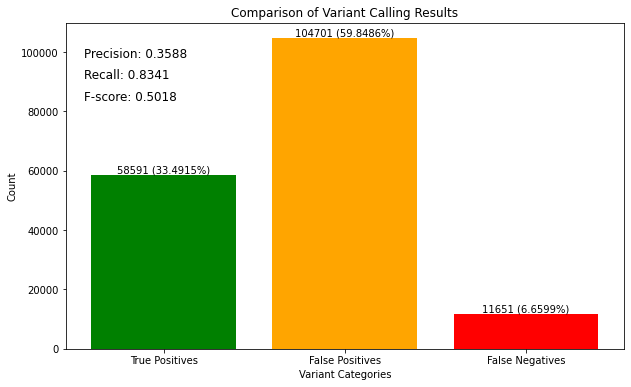

In [21]:
import matplotlib.pyplot as plt

# Data for the bar chart
labels = ['True Positives', 'False Positives', 'False Negatives']
counts = [true_positives, false_positives, false_negatives]

sum_true_false = true_positives + false_positives + false_negatives

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['green', 'orange', 'red'])
plt.xlabel('Variant Categories')
plt.ylabel('Count')
plt.title('Comparison of Variant Calling Results')
plt.text(0, true_positives, f"{true_positives} ({(true_positives * 100 / sum_true_false):.4f}%)", ha='center', va='bottom')
plt.text(1, false_positives, f"{false_positives} ({(false_positives * 100 / sum_true_false):.4f}%)", ha='center', va='bottom')
plt.text(2, false_negatives, f"{false_negatives} ({(false_negatives * 100 / sum_true_false):.4f}%)", ha='center', va='bottom')

# Add metrics
plt.figtext(0.15, 0.8, f'Precision: {precision:.4f}', fontsize=12)
plt.figtext(0.15, 0.75, f'Recall: {recall:.4f}', fontsize=12)
plt.figtext(0.15, 0.7, f'F-score: {f_score:.4f}', fontsize=12)

# Show plot
plt.savefig('bar_chart.png')
plt.show()
